# Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2
from tensorflow.keras import regularizers
from keras.layers import Dropout
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import dateutil
import os
import random
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
random.seed(1)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Preprocess

In [3]:
def pre_process(data):
  # User Name column is not relevent
  data.drop('User Name', 1,inplace=True)

  # Replacing null with 0 and non-null with 1
  data['Personal URL'] = data['Personal URL'].notnull().astype('int')

  # Set --> 1 and not Set --> 0
  data['Profile Cover Image Status'] = np.where(data['Profile Cover Image Status']=='Set', 1, 0)
  #One-hot
  # data = pd.get_dummies(data, columns = ['Profile Cover Image Status'])

  # One-Hot encoding for Profile Verification Status column
  data = pd.get_dummies(data, columns = ['Profile Verification Status'],drop_first=True)


  #Frequnce encoding for Profile Verification Status column
  # enc_prof_verif = (data.groupby('Profile Verification Status').size()) / len(data)
  # data['Profile Verification Status'] = data['Profile Verification Status'].apply(lambda x : enc_prof_verif[x])

  #Frequnce encoding for Color columns
  # data['Profile Theme Color'].fillna(0,inplace = True)
  data['Profile Theme Color'].fillna(data['Profile Theme Color'].value_counts().index[0],inplace = True)
  enc_color_theme = (data.groupby('Profile Theme Color').size()) / len(data)
  data['Profile Theme Color'] = data['Profile Theme Color'].apply(lambda x : enc_color_theme[x])
  # data['Profile Text Color'].fillna(0,inplace = True)
  data['Profile Text Color'].fillna(data['Profile Text Color'].value_counts().index[0],inplace = True)
  enc_color_text = (data.groupby('Profile Text Color').size()) / len(data)
  data['Profile Text Color'] = data['Profile Text Color'].apply(lambda x : enc_color_text[x])
  # data['Profile Page Color'].fillna(0,inplace = True)
  data['Profile Page Color'].fillna(data['Profile Page Color'].value_counts().index[0],inplace = True)
  enc_color_page = (data.groupby('Profile Page Color').size()) / len(data)
  data['Profile Page Color'] = data['Profile Page Color'].apply(lambda x : enc_color_page[x])

  # Mapping True/False --> 1/0
  data['Is Profile View Size Customized?'] = data['Is Profile View Size Customized?'].astype(int)
  # One_hot
  # data = pd.get_dummies(data, columns = ['Is Profile View Size Customized?'])

  # Dropping irrelevant Cols (Maybe we should use them)
  # data.drop(['UTC Offset', 'Location'], axis=1, inplace=True)
  data.drop(['Location'], axis=1, inplace=True)
  data['UTC Offset'].fillna(data['UTC Offset'].value_counts().index[0],inplace = True)
  # data['Location'].fillna(data['Location'].value_counts().index[0],inplace = True)
  # data = pd.get_dummies(data, columns = ['UTC Offset'],drop_first=True)
  enc_utc = (data.groupby('UTC Offset').size()) / len(data)
  data['UTC Offset'] = data['UTC Offset'].apply(lambda x : enc_utc[x])

  # Enabled --> 1 and Disabled or ??? --> 0
  data['Location Public Visibility'] = np.where(data['Location Public Visibility'].str.lower() == 'enabled', 1, 0)
  # data = pd.get_dummies(data, columns = ['Location Public Visibility'])

  # Frequency encoding for user language
  enc_user_lang = (data.groupby('User Language').size()) / len(data)
  data['User Language'] = data['User Language'].apply(lambda x : enc_user_lang[x])
  #One-Hot
  # data = pd.get_dummies(data, columns = ['User Language'],drop_first=True)

  # Frequency encoding for User time zone
  data['User Time Zone'].fillna(data['User Time Zone'].value_counts().index[0],inplace = True)
  enc_time_zone = (data.groupby('User Time Zone').size()) / len(data)
  data['User Time Zone'] = data['User Time Zone'].apply(lambda x : enc_time_zone[x])

  # Replacing the white spaces with nan
  data['Profile Category'] = data['Profile Category'].replace(r'^\s*$', np.nan, regex=True)
  # Replacing nan with 'unknown'
  data['Profile Category'].fillna('unknown',inplace = True)

  # One-hot encoding
  data = pd.get_dummies(data, columns = ['Profile Category'],drop_first=True)

  # Frequency encoding for profile category
  # enc_prof_cat = (data.groupby('Profile Category').size()) / len(data)
  # data['Profile Category'] = data['Profile Category'].apply(lambda x : enc_prof_cat[x])


  # Median imputation for 'Avg Daily Profile Clicks'And'Avg Daily Profile Visit Duration in seconds'
  imp_median = SimpleImputer( strategy='median') #for median imputation replace 'mean' with 'median'
  imp_median.fit(data[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']])
  imputed_train_df = imp_median.transform(data[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']])
  imputed_train_df = pd.DataFrame(imputed_train_df,columns=['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds'])
  data[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']] = imputed_train_df[['Avg Daily Profile Clicks','Avg Daily Profile Visit Duration in seconds']]

  # Removing Outliers
  # Q1 = data['Num of Followers'].quantile(0.25)
  # Q3 = data['Num of Followers'].quantile(0.75)
  # IQR = Q3 - Q1
  # Q3 + 1.5 * IQR
  # data = data[data['Num of Followers'] <(Q3 + 1.5 * IQR)]

  # Making Id column as index
  data.set_index('Id',inplace=True)

  # Dropping Pic Col for now
  data.drop('Profile Image', 1,inplace=True)
  # Dropping Personal Url column
  #data.drop('Personal URL', 1,inplace=True)

  #Parsing Number of years until 2020
  data['Profile Creation Timestamp'] = data['Profile Creation Timestamp'].apply(lambda x: dateutil.parser.parse(x))
  data['Profile Creation Timestamp']=pd.DatetimeIndex(data['Profile Creation Timestamp']).year
  data['Profile Creation Timestamp'] = 2020-data['Profile Creation Timestamp']

  #Binning Avg Daily Profile Visit Duration in seconds
  bins = [10.685,14.795,18.03,20.691,23.205,25.48,28.132,31.091,34.595,48.885]
  # labels = [1,2,3,4,5]
  data['Avg_seconds_binned'] = pd.cut(data['Avg Daily Profile Visit Duration in seconds'], bins=bins)
  # data["Avg_seconds_binned"] = pd.qcut(data["Avg Daily Profile Visit Duration in seconds"], q=10)
  data = pd.get_dummies(data, columns = ['Avg_seconds_binned'],drop_first=True)
  data.drop('Avg Daily Profile Visit Duration in seconds', 1,inplace=True)
 


  return data




In [4]:
df_train = pre_process(pd.read_csv("/content/gdrive/MyDrive/ift6758-a20/train.csv"))
df_test = pre_process(pd.read_csv("/content/gdrive/MyDrive/ift6758-a20/test.csv")) 

In [6]:
end_y_outlier = 200000

In [7]:
# Removing Outliers
#df_train = df_train.drop(df_train[df_train['Num of Profile Likes']1].index)
df_train = df_train.drop(df_train[df_train['Num of Profile Likes']>end_y_outlier].index)
df_train = df_train.drop(df_train[df_train['Num of Direct Messages']>150000].index)
df_train = df_train.drop(df_train[df_train['Num of Status Updates']>1500000].index)
df_train = df_train.drop(df_train[df_train['Num of Followers']>40000000].index)

In [8]:
num_features = df_train[['Avg Daily Profile Clicks','Num of Followers','Num of People Following','Num of Status Updates','Num of Direct Messages']]

In [9]:
num_features_test = df_test[['Avg Daily Profile Clicks','Num of Followers','Num of People Following','Num of Status Updates','Num of Direct Messages']]

In [10]:
y_col = ['Num of Profile Likes']
x_col = df_train.columns.difference(['Num of Profile Likes'])

In [11]:
for i in num_features.columns:
  df_train[i] = np.log1p(df_train[i])

In [12]:
for i in num_features_test.columns:
  df_test[i] = np.log1p(df_test[i])

In [13]:
df_train.head()

,Personal URL,Profile Cover Image Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location Public Visibility,User Language,Profile Creation Timestamp,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Clicks,Num of Profile Likes,Profile Verification Status_Pending,Profile Verification Status_Verified,Profile Category_celebrity,Profile Category_government,Profile Category_unknown,"Avg_seconds_binned_(14.795, 18.03]","Avg_seconds_binned_(18.03, 20.691]","Avg_seconds_binned_(20.691, 23.205]","Avg_seconds_binned_(23.205, 25.48]","Avg_seconds_binned_(25.48, 28.132]","Avg_seconds_binned_(28.132, 31.091]","Avg_seconds_binned_(31.091, 34.595]","Avg_seconds_binned_(34.595, 48.885]"
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL85S14OMDPF01I9,0,1,0.000133,0.000133,0.000133,0,0.008133,1,0.709467,12,0.005067,11.469642,8.364042,10.335595,6.773080,0.946277,2815,0,1,0,0,0,0,0,0,0,0,0,0,0
HI11QOPD7BLJTO7Q,0,1,0.005867,0.006267,0.004267,0,0.240000,1,0.709467,10,0.225467,13.834084,5.669881,9.005896,5.673323,2.507825,1242,0,1,0,0,1,0,0,0,0,0,0,0,0
JS49LP5P72RI1OQB,0,1,0.000133,0.095067,0.000133,0,0.103200,1,0.709467,11,0.068000,9.506363,7.537430,8.455105,5.429346,0.452667,1559,0,0,0,0,1,0,0,0,0,0,0,1,0
S0GDSC09MACCLBJP,1,0,0.000133,0.000400,0.000133,0,0.240000,1,0.709467,11,0.225467,12.734254,7.046647,10.882133,8.303009,1.614724,6342,0,1,0,0,0,0,0,1,0,0,0,0,0
CRSEMK4QER6LDJSA,1,1,0.000133,0.001733,0.138400,0,0.103200,1,0.709467,11,0.068000,9.128696,4.543295,8.093157,4.875197,1.593898,1078,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Standardize features by removing the mean and scaling to unit variance

In [14]:
#Standardization - Train
df_train_stand = df_train.copy()
for i in x_col:
    
    # fit on training data column
    scale = StandardScaler().fit(df_train_stand[[i]])
    
    # transform the training data column
    df_train_stand[i] = scale.transform(df_train_stand[[i]])

In [15]:
# #Standardization - Test
df_test_stand = df_test.copy()
for i in x_col:
    
    # fit on training data column
    scale = StandardScaler().fit(df_test_stand[[i]])
    
    # transform the training data column
    df_test_stand[i] = scale.transform(df_test_stand[[i]])

In [16]:
df_test_stand.head()

,Personal URL,Profile Cover Image Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location Public Visibility,User Language,Profile Creation Timestamp,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Avg Daily Profile Clicks,Profile Verification Status_Pending,Profile Verification Status_Verified,Profile Category_celebrity,Profile Category_government,Profile Category_unknown,"Avg_seconds_binned_(14.795, 18.03]","Avg_seconds_binned_(18.03, 20.691]","Avg_seconds_binned_(20.691, 23.205]","Avg_seconds_binned_(23.205, 25.48]","Avg_seconds_binned_(25.48, 28.132]","Avg_seconds_binned_(28.132, 31.091]","Avg_seconds_binned_(31.091, 34.595]","Avg_seconds_binned_(34.595, 48.885]"
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49I3SOKLI2CMNGP4,-0.842607,0.553939,-0.672092,-0.898982,-0.991759,-0.306744,-0.201833,0.810387,0.632098,0.626117,-0.698913,-0.573458,0.660997,0.173938,-0.093824,0.363523,-0.280207,-1.355612,-0.476755,-0.311404,-0.970048,-0.315253,-0.325124,-0.351562,-0.306744,-0.353712,-0.331107,-0.312947,-0.333333
727IRIR59A3P88LK,-0.842607,-1.805254,-0.470225,-0.885198,-0.991759,-0.306744,-1.609635,0.810387,0.632098,0.626117,-0.975986,-0.448888,-0.347638,0.112489,0.595338,0.300904,-0.280207,-1.355612,-0.476755,3.211264,-0.970048,-0.315253,-0.325124,-0.351562,3.260047,-0.353712,-0.331107,-0.312947,-0.333333
LN95SD15SRPCEE8F,1.186793,0.553939,-0.672092,-0.444120,0.888061,-0.306744,0.399250,0.810387,0.632098,-0.495153,0.700309,2.328575,-0.154778,-0.019158,2.381361,2.476554,-0.280207,0.737674,-0.476755,-0.311404,1.030876,-0.315253,-0.325124,-0.351562,-0.306744,2.827155,-0.331107,-0.312947,-0.333333
TB11I7F0PN033D4T,-0.842607,0.553939,-0.612719,-0.879684,-0.660654,-0.306744,0.399250,-1.233979,0.632098,1.747387,0.700309,0.233201,0.124461,0.048541,0.800088,-0.307266,-0.280207,0.737674,2.097515,-0.311404,-0.970048,-0.315253,-0.325124,-0.351562,-0.306744,2.827155,-0.331107,-0.312947,-0.333333
32PSGCK5PATHMR07,1.186793,0.553939,-0.672092,1.391869,0.380723,-0.306744,1.490692,0.810387,0.632098,-1.055788,1.577709,-1.899801,0.549024,-1.361331,-2.118036,0.594465,-0.280207,-1.355612,-0.476755,-0.311404,1.030876,3.172057,-0.325124,-0.351562,-0.306744,-0.353712,-0.331107,-0.312947,-0.333333


In [21]:
# pearson's correlation feature selection 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
# define feature selection
fs = SelectKBest(score_func=mutual_info_regression, k='all')
# apply feature selection
X_selected = fs.fit_transform(df_train_stand[x_col], df_train_stand[y_col].values.ravel())
names = df_train_stand[x_col].columns.values[fs.get_support()]
scores = fs.scores_[fs.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

                              Feat_names  F_Scores
15                          Personal URL  0.242404
14                 Num of Status Updates  0.127864
13               Num of People Following  0.122654
0               Avg Daily Profile Clicks  0.090525
11                Num of Direct Messages  0.056677
12                      Num of Followers  0.056263
18              Profile Category_unknown  0.042424
26                            UTC Offset  0.038924
10            Location Public Visibility  0.034167
28                        User Time Zone  0.031336
27                         User Language  0.029885
20            Profile Creation Timestamp  0.024382
25  Profile Verification Status_Verified  0.023706
16            Profile Category_celebrity  0.022705
22                    Profile Text Color  0.014056
19            Profile Cover Image Status  0.010369
21                    Profile Page Color  0.008737
6    Avg_seconds_binned_(28.132, 31.091]  0.007520
9       Is Profile View Size Cu

In [18]:
from sklearn.feature_selection import SelectPercentile, chi2
percentileDriven = SelectPercentile(chi2, percentile=90)
X_selected_percentile = percentileDriven.fit_transform(df_train[x_col], df_train[y_col].values.ravel())
scores = percentileDriven.scores_[percentileDriven.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted_ = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted_)

                              Feat_names     F_Scores
17           Profile Category_government  4212.485672
6    Avg_seconds_binned_(28.132, 31.091]  3982.383427
16            Profile Category_celebrity  3953.025202
8    Avg_seconds_binned_(34.595, 48.885]  3941.868557
1     Avg_seconds_binned_(14.795, 18.03]  3883.344224
4     Avg_seconds_binned_(23.205, 25.48]  3852.907740
3    Avg_seconds_binned_(20.691, 23.205]  3800.825698
7    Avg_seconds_binned_(31.091, 34.595]  3779.143503
2     Avg_seconds_binned_(18.03, 20.691]  3752.908914
5     Avg_seconds_binned_(25.48, 28.132]  3692.990942
23                   Profile Theme Color  3430.539288
15                          Personal URL  3234.938708
13               Num of People Following  3165.851710
9       Is Profile View Size Customized?  2938.158294
18              Profile Category_unknown  2313.813547
11                Num of Direct Messages  2093.442995
10            Location Public Visibility  1867.504400
12                      Num 

# Data Selection 

In [22]:
x_col_top_5 = list(ns_df_sorted['Feat_names'][0:5])
x_col_top_6 = list(ns_df_sorted['Feat_names'][0:6])
x_col_top_10 = ns_df_sorted['Feat_names'][0:10]
x_col_top_15 = ns_df_sorted['Feat_names'][0:15]
x_col_top_18 = ns_df_sorted['Feat_names'][0:18]
x_col_top_20 = ns_df_sorted['Feat_names'][0:20]
x_col_top_20 = ns_df_sorted['Feat_names'][0:20]
x_col_all = ns_df_sorted['Feat_names']
x_col_top_24 = ns_df_sorted['Feat_names'][0:24]
x_col_top_21 = ns_df_sorted['Feat_names'][0:21]

# Models

Code using different variants of a Neural Network

In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [24]:
from keras.constraints import max_norm
def setup_model(data_input, columns, width_multiplier=3):
  """ width_first approach """
  num_features = data_input[columns].shape[1]
  model = Sequential()
  # first layer 
  model.add(Dense(num_features*width_multiplier, activation='relu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.001), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
  model.add(Dropout(0.3))
  # hidden layer layer
  model.add(Dense(num_features*width_multiplier, activation='relu', kernel_regularizer=regularizers.l2(0.001), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
  model.add(Dropout(0.3))
  # probably no dropout here {to see?} -> depends on overfit
  model.add(Dense(1, kernel_initializer='normal'))
  print(model.summary())
  return model

  

def setup_model_smaller(data_input, columns, width_multiplier=3):
  num_features = data_input[columns].shape[1]
  model = Sequential()
  model.add(Dense(num_features*1, activation='relu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))
  model.add(Dense(1, kernel_initializer='normal'))
  print(model.summary())
  return model


def setup_deeper_model(data_input, columns):
   """
    depth first approach  
  """
   num_features = data_input[columns].shape[1]
   model = Sequential()
   model.add(Dense(num_features*1, activation='relu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.001)))
   model.add(Dropout(0.3))
   #model.add(Dense(num_features*width_multiplier, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
   model.add(Dense(29*5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
   model.add(Dropout(0.5))
   model.add(Dense(num_features, activation='relu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.001)))
 
   model.add(Dense(1, kernel_initializer='normal'))
   print(model.summary())
   return model
 
def add_model_weighing(data_input, columns):
    from keras.layers import Dense
    from keras.layers import Flatten
    from keras.constraints import max_norm
    num_features = data_input[columns].shape[1]
    model = Sequential()
    model.add(Dense(num_features*1, activation='relu', input_dim=num_features, kernel_regularizer=regularizers.l2(0.001), kernel_constraint=max_norm(3), bias_constraint=max_norm(3) ))
    model.add(Dropout(0.3))
    model.add(Dense(num_features*2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Flatten())
    #model.add(Dropout(0.3))
    # probably no dropout here {to see?} -> depends on overfit
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    return model


In [26]:
from keras.optimizers import Adam
def run_training(data_set, 
                 x_columns, 
                 batch_size=8, 
                 epochs=100, 
                 validation_split=0.2, 
                 width_multiplier=3, 
                 use_deep_model=False,
                 use_smaller=False):
  """
    hyperparameter list 
  """
  

  if use_deep_model:
      model = setup_deeper_model(data_input=data_set, columns=x_columns)
  elif use_smaller:
      model = setup_model_smaller(data_input=data_set, columns=x_columns, width_multiplier=width_multiplier)
  else:
      model = setup_model(data_input=data_set, columns=x_columns, width_multiplier=width_multiplier)
  
  model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics='mean_squared_logarithmic_error')
  history = model.fit(df_train_stand[x_columns] , 
                      df_train[y_col], 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.2, 
                      shuffle=True)
  plot_loss(history)
  return model

def run_training_weights(data_set, 
                 x_columns, 
                 batch_size=8, 
                 epochs=100, 
                 validation_split=0.2, 
                 width_multiplier=3, 
                 use_deep_model=False,
                 use_smaller=False):
  """
    hyperparameter list 
  """
  model = add_model_weighing(data_input=data_set, columns=x_columns)
  model.compile(optimizer=Adam(lr=0.001), 
                loss='mean_squared_logarithmic_error', 
                metrics='mean_squared_logarithmic_error')
  history = model.fit(data_set[x_columns] , 
                      df_train[y_col], 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.1, 
                      shuffle=True)
  plot_loss(history)
  return model

# Training Setup
Permutations of training strategies 
1. Width Multiply Model {15 features, x 10}
2. Deeper Model {capture more of the * features* {use all features}}

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 150)               2400      
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 151       
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
747/747 [==============================] - 2s 2ms/step - loss: 20.2945 - mean_squared_logarithmic_e

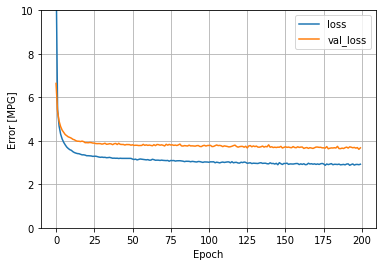

In [34]:
model_22_width_15 = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=10, epochs=200)

In [ ]:
model_22_width_20 = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=20, epochs=200)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 150)               2400      
_________________________________________________________________
dropout_6 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 151       
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 2s 2ms/step - loss: 20.0188 - mean_squared_logarithmic_e

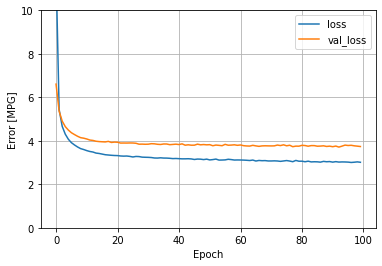

In [36]:
model_22_width_unscaled = run_training(data_set=df_train, x_columns=x_col_top_15, width_multiplier=10, epochs=100)

# Testing

In [32]:
# Submission file
def generate_submission(model_input, columns, file_name):
  y_pred = model_input.predict(df_test_stand[columns])
  y_pred = np.round(y_pred,0)
  dummy = pd.DataFrame()
  dummy["Id"] = df_test.index
  dummy["Predicted"]=y_pred
  dummy.to_csv("{}.csv".format(file_name), sep=',' ,index=False)
  len(y_pred)

15 features, large model, width_multiply 3 

In [35]:
generate_submission(model_22_width_15, x_col_top_15, '200_epochs')

In [37]:
generate_submission(model_22_width_unscaled, x_col_top_15, 'unscaled_data')

15 features, large model, width_multiply 3 

# Cross Validation Approach

In [ ]:
y_selected = df_train[y_col]
from sklearn.model_selection import StratifiedKFold
import numpy
# fix random seed for reproducibility


In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from tensorflow.keras.models import * 
from tensorflow.keras.layers import * 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

input_shape = X_selected.shape

def buildmodel():
    #num_features = 
    model= Sequential([
        Dense(num_features*1, activation='relu', input_dim=input_shape, kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(num_features*3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        #Dropout(0.3), -> might not want this before the last layer {keep as much info before?}
        Dense(num_features*1, activation='relu', kernel_regularizer=regularizers.l2(0.001))

    ])
    model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics='mean_squared_logarithmic_error')
    return(model)

estimator= KerasRegressor(build_fn=buildmodel, epochs=100, batch_size=10, verbose=1)
kfold= RepeatedKFold(n_splits=10, n_repeats=1)
# all features 

#results= cross_val_score(estimator, X_selected, df_train[y_col], cv=kfold, n_jobs=1) 
#results.mean()  # Mean MSE

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: int() argument must be a string, a bytes-like object or a number, not 'DataFrame'

  FitFailedWarning)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_13 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 240)               6000      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 241       
Total params: 6,841
Trainable params: 6,841
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 1s 2ms/step - loss: 13.8832 - mean_squared_logarithmic_error: 13.6945 - val_loss: 7.0673 - val_mean_squared_logarithmic_error: 6.7485
Epoch 2/100
747/747 [==============================] - 

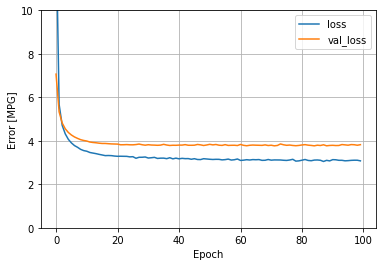

In [ ]:
model_24_width_10 = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=10) #validation error # 3,67

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 45)                720       
_________________________________________________________________
dropout_27 (Dropout)         (None, 45)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 150)               6900      
_________________________________________________________________
dropout_28 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 151       
Total params: 7,771
Trainable params: 7,771
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 1s 2ms/step - loss: 14.0360 - mean_squared_logarithmic_er

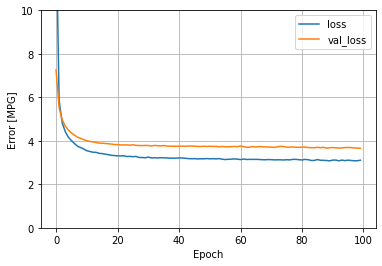

In [ ]:
model_15_width_10 = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=10) #validation error 3.5130

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 150)               2400      
_________________________________________________________________
dropout_29 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_30 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 151       
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 1s 2ms/step - loss: 11.9062 - mean_squared_logarithmic_

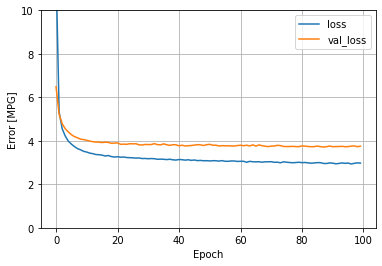

In [ ]:
model_15_width_10_both_layers = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=10) #v

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_15 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 150)               2400      
_________________________________________________________________
dropout_16 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 151       
Total params: 2,791
Trainable params: 2,791
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 1s 2ms/step - loss: 16.8296 - mean_squared_logarithmic_er

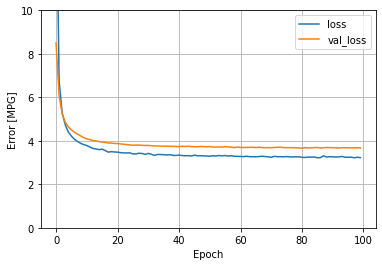

In [ ]:
# with dropoput + max_on levels
model_15_width_10_dropout = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=10) #validation error #3,59

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_17 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 180)               3420      
_________________________________________________________________
dropout_18 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 181       
Total params: 3,943
Trainable params: 3,943
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 1s 2ms/step - loss: 15.7964 - mean_squared_logarithmic_er

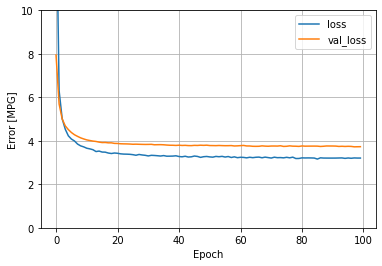

In [ ]:
# with dropoput + max_on levels
model_18_width_10_dropout = run_training(data_set=df_train_stand, x_columns=x_col_top_18, width_multiplier=10) #validation error #3,59

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 150)               2400      
_________________________________________________________________
dropout_35 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_36 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 151       
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
747/747 [==============================] - 2s 2ms/step - loss: 11.8386 - mean_squared_logarithmic_

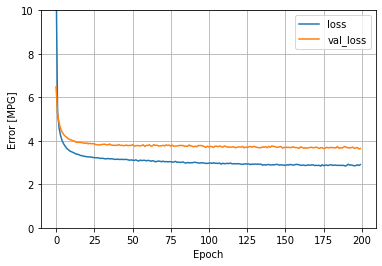

In [ ]:
# with dropoput + max_on levels 
model_15_width_10_dropout = run_training(data_set=df_train, x_columns=x_col_top_15, width_multiplier=10, epochs=200) #validation error #3.5666/3.5185

In [ ]:
# with dropoput + max_on levels
model_18_width_20_dropout = run_training(data_set=df_train, x_columns=x_col_top_18, width_multiplier=20) #validation error 

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 18)                342       
_________________________________________________________________
dropout_25 (Dropout)         (None, 18)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 360)               6840      
_________________________________________________________________
dropout_26 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 361       
Total params: 7,543
Trainable params: 7,543
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 2s 2ms/step - loss: 14.1107 - mean_squared_logarithmic_er

KeyboardInterrupt: ignored

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 29)                870       
_________________________________________________________________
dropout_21 (Dropout)         (None, 29)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 290)               8700      
_________________________________________________________________
dropout_22 (Dropout)         (None, 290)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 291       
Total params: 9,861
Trainable params: 9,861
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 2s 2ms/step - loss: 13.1126 - mean_squared_logarithmic_er

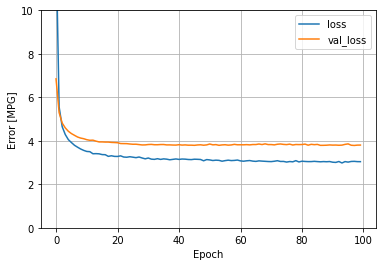

In [ ]:
# with dropoput + max_on levels
model_15_width_all_dropout = run_training(data_set=df_train, x_columns=x_col_all, width_multiplier=10) #validation error #3.5666

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 150)               2400      
_________________________________________________________________
dropout_37 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_38 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 151       
Total params: 25,201
Trainable params: 25,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
747/747 [==============================] - 2s 2ms/step - loss: 12.0322 - mean_squared_logarithmic_

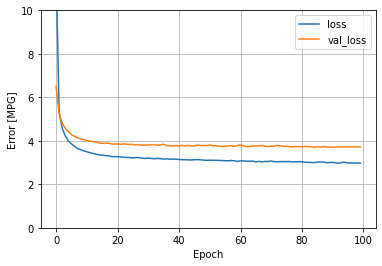

In [ ]:
model_15_width_all_dropout_standardize_features = run_training(data_set=df_train_stand, x_columns=x_col_top_15, width_multiplier=10) 

In [ ]:
generate_submission(model_15_width_10_dropout, x_col_top_15, 'model_15_width_10_dropout')

In [ ]:
generate_submission(model_15_width_10_dropout, x_col_top_15, 'model_15_width_10_larger_first_layer')